# Adaptive rejection sampling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Verify that the function is log-concave

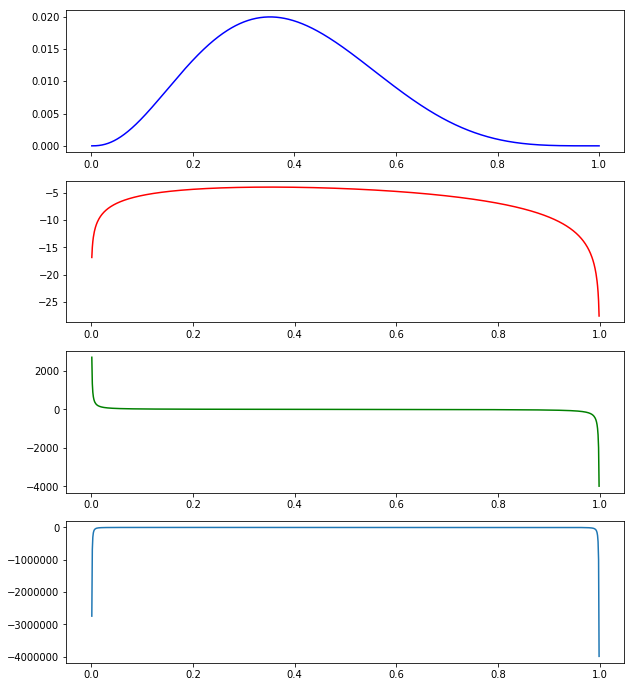

In [2]:
LEFT_BOUND = 0
RIGHT_BOUND = 1


def f(x):
    return (-np.log(x))**2*(x**3)*((1-x)**2)

def logf(x):
    return np.log(f(x))

def logf1(x):
    return (-2*x - 5*x*np.log(x) + 3*np.log(x) + 2)/(x*np.log(x) - x**2*np.log(x))

def logf2(x):
    return  ((-5*x**2 + 6*x - 3)/(x - 1)**2 - 2/(np.log(x)**2) - 2/np.log(x))/x**2


x = np.linspace(LEFT_BOUND, RIGHT_BOUND, 1000)

plt.figure(1, figsize=(10,12))

plt.subplot(411)
plt.plot(x, f(x), 'b')

plt.subplot(412)
plt.plot(x, logf(x), 'r')

plt.subplot(413)
plt.plot(x, logf1(x), 'g')

plt.subplot(414)
plt.plot(x, logf2(x))


plt.show()

In [3]:
#set up a table for easy reference of the piece-wise 'hat'

tangent_table = pd.DataFrame(columns=['x1', 'y1', 'm', 'b','lb','rb','area','w'])
tangent_table

,x1,y1,m,b,lb,rb,area,w


In [4]:
#algorithm for updating table with a new point, there are 3 separate cases to consider:
#1) new tangent point is the left most one
#2) new tangent point is the right most one
#3) new tangent point falls between two existing tangent points

#Based on the scenario, a few updates to the pre-existing points must take place, the bounds are changed and the area under
# the corresponding segments change.

def update_row(row_num):
    if row_num == 0 and row_num == (len(tangent_table) - 1):
        lb = LEFT_BOUND
        rb = RIGHT_BOUND
        
        tangent_table.iloc[row_num]['lb'] = lb
        tangent_table.iloc[row_num]['rb'] = rb
        
    elif row_num == 0:
        y2 = tangent_table.iloc[row_num]['y1']
        m2 = tangent_table.iloc[row_num]['m']
        x2 = tangent_table.iloc[row_num]['x1']
        b2 = y2 - m2*x2
        tangent_table.iloc[row_num]['b'] = b2
        y3 = tangent_table.iloc[row_num+1]['y1']
        m3 = tangent_table.iloc[row_num+1]['m']
        x3 = tangent_table.iloc[row_num+1]['x1']
        b3 = y3 - m3*x3
        tangent_table.iloc[row_num+1]['b'] = b3
        
        lb = LEFT_BOUND
        rb = (b3 - b2)/(m2 - m3)
        
        tangent_table.iloc[row_num]['lb'] = lb
        tangent_table.iloc[row_num]['rb'] = rb
        tangent_table.iloc[row_num+1]['lb'] = rb
        
        
        lb2 = lb
        rb2 = rb
        
        lb3 = rb
        rb3 = tangent_table.iloc[row_num+1]['rb']
        
        tangent_table.iloc[row_num]['area'] = (np.e**(m2*rb2 + b2) - np.e**(m2*lb2 + b2))/m2
        tangent_table.iloc[row_num+1]['area'] = (np.e**(m3*rb3 + b3) - np.e**(m3*lb3 + b3))/m3
        
    elif row_num == (len(tangent_table)-1):
        y1 = tangent_table.iloc[row_num-1]['y1']
        m1 = tangent_table.iloc[row_num-1]['m']
        x1 = tangent_table.iloc[row_num-1]['x1']
        b1 = y1 - m1*x1
        tangent_table.iloc[row_num-1]['b'] = b1
        y2 = tangent_table.iloc[row_num]['y1']
        m2 = tangent_table.iloc[row_num]['m']
        x2 = tangent_table.iloc[row_num]['x1']
        b2 = y2 - m2*x2
        tangent_table.iloc[row_num]['b'] = b2
                     
        lb = (b2 - b1)/(m1 - m2)
        rb = RIGHT_BOUND
        
        tangent_table.iloc[row_num-1]['rb'] = lb
        tangent_table.iloc[row_num]['lb'] = lb
        tangent_table.iloc[row_num]['rb'] = rb
        
        lb1 = tangent_table.iloc[row_num-1]['lb']
        rb1 = lb
        
        lb2 = lb
        rb2 = rb
        
        tangent_table.iloc[row_num-1]['area'] = (np.e**(m1*rb1 + b1) - np.e**(m1*lb1 + b1))/m1
        tangent_table.iloc[row_num]['area'] = (np.e**(m2*rb2 + b2) - np.e**(m2*lb2 + b2))/m2
                     
    else:
        y1 = tangent_table.iloc[row_num-1]['y1']
        m1 = tangent_table.iloc[row_num-1]['m']
        x1 = tangent_table.iloc[row_num-1]['x1']
        b1 = y1 - m1*x1
        tangent_table.iloc[row_num-1]['b'] = b1
        y2 = tangent_table.iloc[row_num]['y1']
        m2 = tangent_table.iloc[row_num]['m']
        x2 = tangent_table.iloc[row_num]['x1']
        b2 = y2 - m2*x2
        tangent_table.iloc[row_num]['b'] = b2
        y3 = tangent_table.iloc[row_num+1]['y1']
        m3 = tangent_table.iloc[row_num+1]['m']
        x3 = tangent_table.iloc[row_num+1]['x1']
        b3 = y3 - m3*x3
        tangent_table.iloc[row_num+1]['b'] = b3
                     
        lb = (b2 - b1)/(m1 - m2)
        rb = (b3 - b2)/(m2 - m3)
                     
        tangent_table.iloc[row_num-1]['rb'] = lb
        tangent_table.iloc[row_num]['lb'] = lb
        tangent_table.iloc[row_num]['rb'] = rb
        tangent_table.iloc[row_num+1]['lb'] = rb
        
        lb1 = tangent_table.iloc[row_num-1]['lb']
        rb1 = lb
        
        lb2 = lb
        rb2 = rb
        
        lb3 = rb
        rb3 = tangent_table.iloc[row_num+1]['rb']
        
        tangent_table.iloc[row_num-1]['area'] = (np.e**(m1*rb1 + b1) - np.e**(m1*lb1 + b1))/m1
        tangent_table.iloc[row_num]['area'] = (np.e**(m2*rb2 + b2) - np.e**(m2*lb2 + b2))/m2
        tangent_table.iloc[row_num+1]['area'] = (np.e**(m3*rb3 + b3) - np.e**(m3*lb3 + b3))/m3
        
    total_area = np.sum(tangent_table['area'])
    tangent_table['w'] = tangent_table['area']/total_area


In [5]:
#method used to insert a new tangent point into the graph, ensures that no duplicates occur from user error, and sorts tangent
# points from left to right from bottom to top

def insert_row(x1):
    global tangent_table
    if len(np.where(tangent_table['x1'] == x1)[0]) == 0:
        tangent_table.loc[len(tangent_table)] = [x1, logf(x1), logf1(x1), np.nan, np.nan, np.nan, np.nan, np.nan]
        tangent_table = tangent_table.sort_values(['x1'], axis=0, ascending=True).reset_index(drop=True)
        
        row_num = np.where(tangent_table['x1'] == x1)[0][0]
        update_row(row_num)
    else:
        print("x1 = {} is already contained in the table.".format(x1))

In [6]:
#samples one point from the current piecewise 'hat'
#returns boolean for success/failure and the x value that was picked

def sample():
    
    #choose a piecewise line to sample from based on weights
    rand = random.random()
    row = 0
    while rand > 0:
        rand -= tangent_table['w'][row]
        row += 1
    row -= 1
    
    #generate x from chosen line using inverse cdf:
    #l is normalization constant, or just the area variable
    #q is left bound of line
    U = random.random()
    l = tangent_table.iloc[row]['area']
    m = tangent_table.iloc[row]['m']
    b = tangent_table.iloc[row]['b']
    lb = tangent_table.iloc[row]['lb']
    x = (np.log(l*m*U + np.e**(m*lb + b)) - b)/(m)
    
    w = random.random()
    y = logf(x)
    
    if w < np.e**(y-(m*x+b)):
        return True, x
    else:
        return False, x
    

### Pick two initial points

In [7]:
#reset the tangents, either pick two suitable points or pick at random
random.seed(42)
x1 = .2 # random.random()
x2 = .6 # random.random()

insert_row(x1)
insert_row(x2)

In [8]:
tangent_table

,x1,y1,m,b,lb,rb,area,w
0,0.2,-4.322831,6.286651,-5.580161,0.000000,0.373624,0.005684,0.488464
1,0.6,-4.708512,-6.525384,-0.793282,0.373624,1.000000,0.005952,0.511536


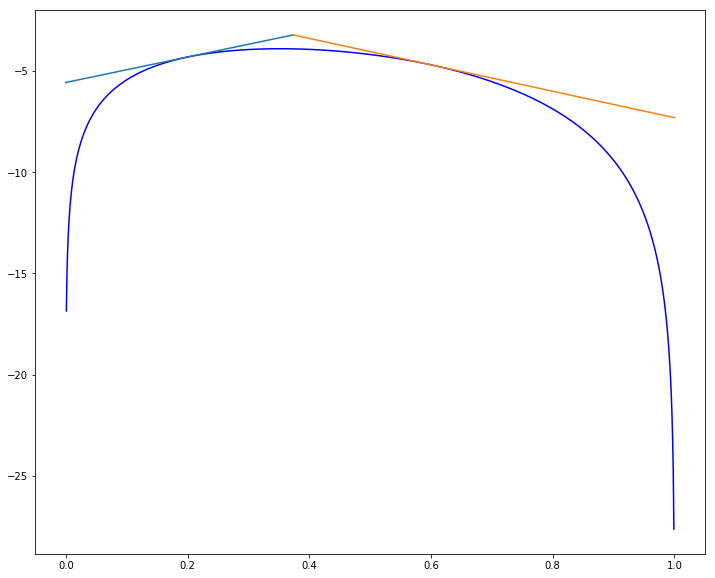

In [9]:
def line(x, m, b):
    return m*x + b

x = np.linspace(LEFT_BOUND, RIGHT_BOUND, 1000)

xi = [np.linspace(row[1]['lb'], row[1]['rb'], 1000) for row in tangent_table.iterrows()]



plt.figure(1, figsize=(12,10))
plt.plot(x, logf(x), 'b')
for i, x in enumerate(xi):
    plt.plot(x, line(x, tangent_table.iloc[i]['m'], tangent_table.iloc[i]['b']))

plt.show()

### adaptive sampling

In [10]:
#Now let's sample but instead feed failures back into the table, and compare results


N = -1 #cutoff for the number of lines wanted, -1 means no limit

samples = []
rejected = []
while len(samples) < 40000:
    accept, val = sample()
    if accept:
        samples += [val]
    else:
        rejected += [val]
        if N == -1 or (len(tangent_table < N)):
            insert_row(val)

In [11]:
print('Piecewise lines after simulation: {}'.format(len(tangent_table)))

Piecewise lines after simulation: 63


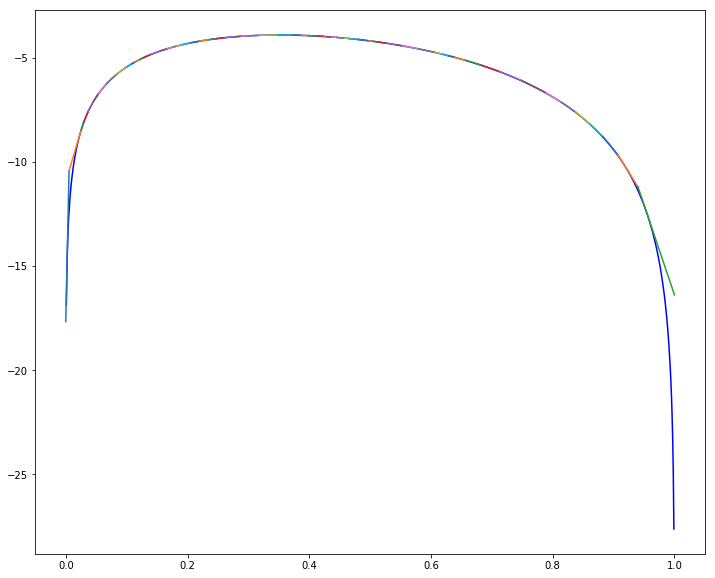

In [12]:
def line(x, m, b):
    return m*x + b

x = np.linspace(LEFT_BOUND, RIGHT_BOUND, 1000)

xi = [np.linspace(row[1]['lb'], row[1]['rb'], 1000) for row in tangent_table.iterrows()]



plt.figure(1, figsize=(12,10))
plt.plot(x, logf(x), 'b')
for i, x in enumerate(xi):
    plt.plot(x, line(x, tangent_table.iloc[i]['m'], tangent_table.iloc[i]['b']))

plt.show()

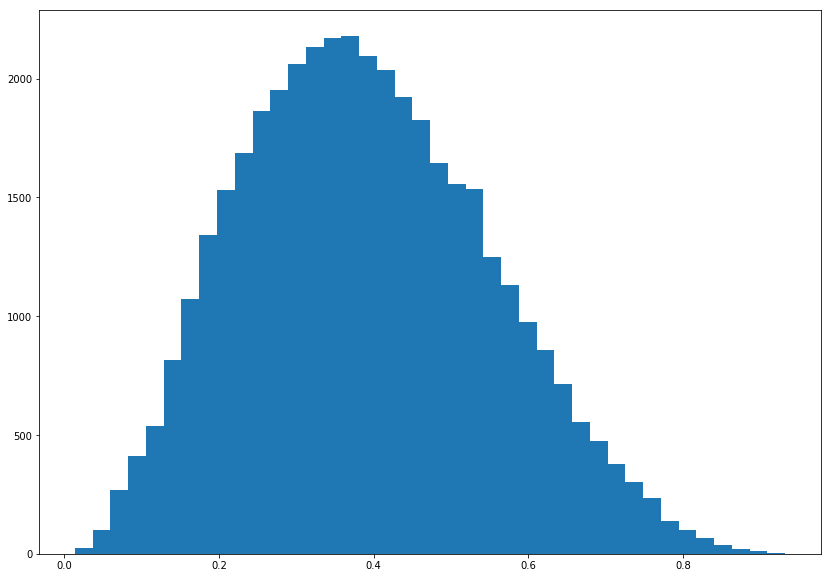

In [13]:
figure = plt.figure(figsize=(14, 10))
plt.hist(samples, bins=40)
plt.show()

In [14]:
#Acceptance rate for two lines:
#Area under f(x) from 0 to 1: 919/108000

#This calculation could be more precise after freezing the adaptive algorithm, but even with a suboptimal start the algorithm
#quickly improves its accuracy.

area1 = 919/108000
#Area under piecewise 'hat'
area2 = np.sum(tangent_table['area'])

print("Theoretical acceptance rate given {} lines: {}".format(len(tangent_table), area1/area2))
print("Actual acceptance rate from simulation (including adaptive failures): {}"\
      .format(len(samples)/(len(samples)+len(rejected))))

Theoretical acceptance rate given 63 lines: 0.9991805536713767
Actual acceptance rate from simulation (including adaptive failures): 0.9984773220838221
